#Регрессия для SI

In [30]:
!pip install -q catboost
!pip install -q optuna

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer

import xgboost as xgb
import catboost as cb
import lightgbm as lgb
import optuna

import warnings
warnings.filterwarnings('ignore')

In [31]:
# Загрузка данных через диалоговое окно
from google.colab import files
uploaded = files.upload()

df = pd.read_csv('selected_features_SI.csv')

Saving selected_features_SI.csv to selected_features_SI (1).csv


In [32]:
df.head()

,BalabanJ,MinAbsEStateIndex,BCUT2D_LOGPHI,SMR_VSA5,VSA_EState4,MinPartialCharge,EState_VSA2,BCUT2D_LOGPLOW,MinAbsPartialCharge,Kappa3,...,MolLogP,fr_C_O,FractionCSP3,SMR_VSA7,FpDensityMorgan1,SlogP_VSA4,NumSaturatedHeterocycles,fr_Al_COO,SlogP_VSA10,SI
0,1.164038,0.387225,2.644698,105.750639,4.807589,-0.293526,0.000000,-2.322229,0.038844,2.868737,...,7.1212,0,0.923077,0.00000,0.642857,33.495774,0,0,0.000000,28.125000
1,1.080362,0.533868,2.658342,117.834321,2.153503,-0.313407,0.000000,-2.444817,0.012887,3.027177,...,6.1556,0,1.000000,0.00000,0.607143,33.495774,0,0,0.000000,7.000000
2,1.219066,0.543231,2.679014,117.834321,2.184127,-0.325573,0.000000,-2.565224,0.094802,3.470070,...,7.1292,0,1.000000,0.00000,0.562500,33.495774,0,0,0.000000,0.720000
3,1.120513,0.390603,2.644709,112.171461,4.827852,-0.293526,0.000000,-2.322030,0.038844,3.263848,...,7.5113,0,0.925926,0.00000,0.620690,33.495774,0,0,0.000000,63.235294
4,1.136678,0.270476,2.648473,86.488175,9.071783,-0.257239,10.829981,-2.318893,0.062897,3.345855,...,9.1148,0,0.575758,59.65784,0.600000,33.495774,0,0,11.374773,1.300000


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 998 entries, 0 to 997
Data columns (total 26 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   BalabanJ                  998 non-null    float64
 1   MinAbsEStateIndex         998 non-null    float64
 2   BCUT2D_LOGPHI             998 non-null    float64
 3   SMR_VSA5                  998 non-null    float64
 4   VSA_EState4               998 non-null    float64
 5   MinPartialCharge          998 non-null    float64
 6   EState_VSA2               998 non-null    float64
 7   BCUT2D_LOGPLOW            998 non-null    float64
 8   MinAbsPartialCharge       998 non-null    float64
 9   Kappa3                    998 non-null    float64
 10  SlogP_VSA3                998 non-null    float64
 11  AvgIpc                    998 non-null    float64
 12  Chi3n                     998 non-null    float64
 13  RingCount                 998 non-null    int64  
 14  BertzCT   

In [34]:
if 'Unnamed: 0' in df.columns:
    df = df.drop(columns=['Unnamed: 0'])

# Подготовка и анализ данных

In [35]:
# Вычисляем логарифм от IC50
if 'SI_log' not in df.columns:
    df['SI_log'] = -np.log10(df['SI'])
    print("Логарифмированная целевая переменная добавлена (SI)")

Логарифмированная целевая переменная добавлена (SI)


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 998 entries, 0 to 997
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   BalabanJ                  998 non-null    float64
 1   MinAbsEStateIndex         998 non-null    float64
 2   BCUT2D_LOGPHI             998 non-null    float64
 3   SMR_VSA5                  998 non-null    float64
 4   VSA_EState4               998 non-null    float64
 5   MinPartialCharge          998 non-null    float64
 6   EState_VSA2               998 non-null    float64
 7   BCUT2D_LOGPLOW            998 non-null    float64
 8   MinAbsPartialCharge       998 non-null    float64
 9   Kappa3                    998 non-null    float64
 10  SlogP_VSA3                998 non-null    float64
 11  AvgIpc                    998 non-null    float64
 12  Chi3n                     998 non-null    float64
 13  RingCount                 998 non-null    int64  
 14  BertzCT   

In [37]:
# Определяем целевую переменную
TARGET_COL = 'SI_log'

# Копируем датафрейм
df_clean = df.copy()

# Оригинальный логарифмированный pIC50
original_true = df[TARGET_COL].copy()

In [38]:
# Ограничение выбросов в логарифмированной переменной
def cap_outliers(series, lower_percentile=0.01, upper_percentile=0.99):
    lower_cap = series.quantile(lower_percentile)
    upper_cap = series.quantile(upper_percentile)
    return np.clip(series, lower_cap, upper_cap)

df_clean[TARGET_COL] = cap_outliers(df_clean[TARGET_COL])
print("Выбросы в SI ограничены")

Выбросы в SI ограничены


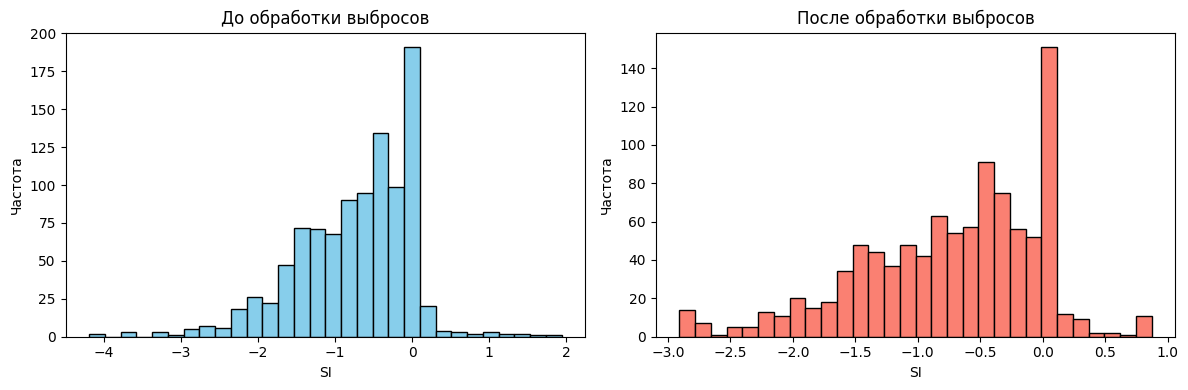

In [39]:
# Оригинальное и обработанное значение
original = original = original_true.copy()
capped = df_clean[TARGET_COL]

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(original, bins=30, color='skyblue', edgecolor='black')
plt.title('До обработки выбросов')
plt.xlabel('SI')
plt.ylabel('Частота')

plt.subplot(1, 2, 2)
plt.hist(capped, bins=30, color='salmon', edgecolor='black')
plt.title('После обработки выбросов')
plt.xlabel('SI')
plt.ylabel('Частота')

plt.tight_layout()
plt.show()


"Хвосты" жёстко обрезаны — отсекаем верхние и нижние 1% значений по распределению.
Это снижает влияние экстремальных выбросов, особенно актуально для деревьев, бустинга и CatBoost, которые менее чувствительны к распределению целевой переменной.

Линейные модели более чувствительны к асимметрии и выбросам

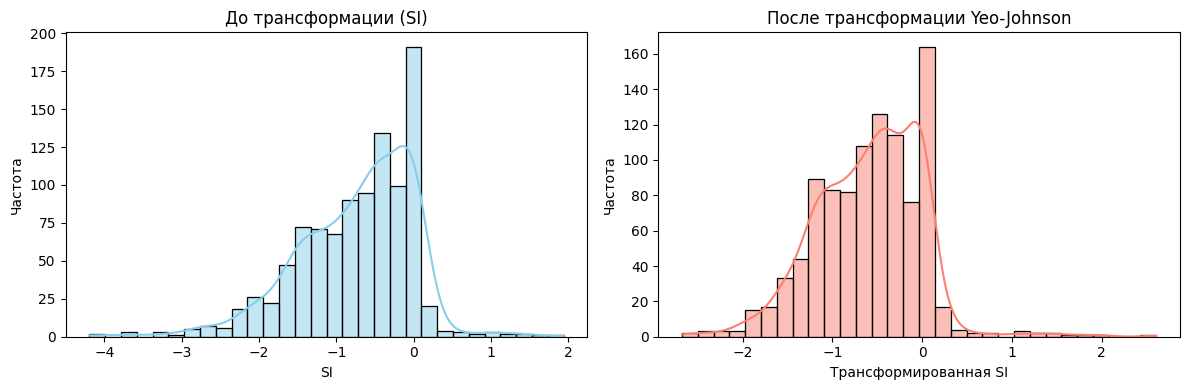

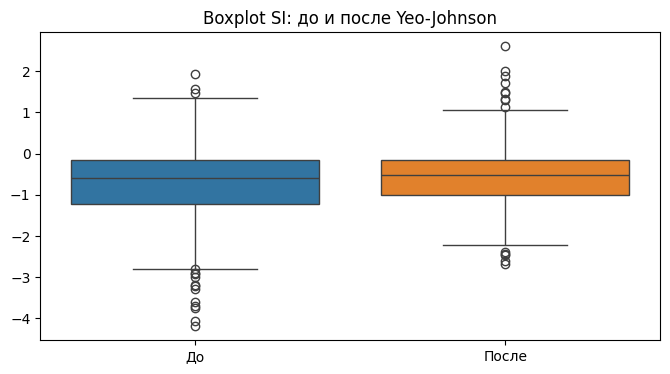

In [40]:
# Оригинальная логарифмированная целевая переменная
original = original_true.copy()

# Применяем Yeo-Johnson только для анализа
pt = PowerTransformer(method='yeo-johnson', standardize=False)
transformed = pt.fit_transform(original.values.reshape(-1, 1)).flatten()

# Визуализация распределений
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
sns.histplot(original, bins=30, kde=True, color='skyblue')
plt.title("До трансформации (SI)")
plt.xlabel("SI")
plt.ylabel("Частота")

plt.subplot(1, 2, 2)
sns.histplot(transformed, bins=30, kde=True, color='salmon')
plt.title("После трансформации Yeo-Johnson")
plt.xlabel("Трансформированная SI")
plt.ylabel("Частота")

plt.tight_layout()
plt.show()

# Дополнительно: boxplot
plt.figure(figsize=(8, 4))
sns.boxplot(data=[original, transformed])
plt.xticks([0, 1], ['До', 'После'])
plt.title('Boxplot SI: до и после Yeo-Johnson')
plt.show()

делаем предобработку исхъодного датасета

In [41]:
# Выделяем числовые признаки (кроме целевых)
feature_cols = [col for col in df_clean.columns if col not in ['SI', 'SI_log']]

In [42]:
print(feature_cols)

['BalabanJ', 'MinAbsEStateIndex', 'BCUT2D_LOGPHI', 'SMR_VSA5', 'VSA_EState4', 'MinPartialCharge', 'EState_VSA2', 'BCUT2D_LOGPLOW', 'MinAbsPartialCharge', 'Kappa3', 'SlogP_VSA3', 'AvgIpc', 'Chi3n', 'RingCount', 'BertzCT', 'NHOHCount', 'MolLogP', 'fr_C_O', 'FractionCSP3', 'SMR_VSA7', 'FpDensityMorgan1', 'SlogP_VSA4', 'NumSaturatedHeterocycles', 'fr_Al_COO', 'SlogP_VSA10']


In [43]:
# Разделяем данные
X = df_clean[feature_cols].copy()
y = df_clean['SI_log'].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [44]:
# Стандартизация признаков (применяем к тренировочной выборке)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [45]:
# Преобразуем обратно в DataFrame для удобства
X_train = pd.DataFrame(X_train_scaled, columns=feature_cols, index=X_train.index)
X_test = pd.DataFrame(X_test_scaled, columns=feature_cols, index=X_test.index)

# Построение и оценка моделей

In [46]:
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    """Оценка модели"""
    model.fit(X_train, y_train)

    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    train_mae = mean_absolute_error(y_train, y_pred_train)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)

    test_acc = np.mean(np.abs(y_test - y_pred_test) < 0.5)

    cv_rmse = np.sqrt(-cross_val_score(model, X_train, y_train, cv=5,
                                       scoring='neg_mean_squared_error').mean())

    results = {
        'Model': model_name,
        'Train_RMSE': train_rmse,
        'Test_RMSE': test_rmse,
        'Train_MAE': train_mae,
        'Test_MAE': test_mae,
        'Train_R2': train_r2,
        'Test_R2': test_r2,
        'Test_Acc(±0.5)': test_acc,
        'CV_RMSE': cv_rmse
    }

    return results, y_pred_test

In [47]:
def plot_predictions(y_test, y_pred, model_name):
    """предсказания vs реальные значения"""
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.6)

    # Линия идеального предсказания
    min_val = min(y_test.min(), y_pred.min())
    max_val = max(y_test.max(), y_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Идеальное предсказание')

    plt.xlabel('Реальные значения')
    plt.ylabel('Предсказанные значения')
    plt.title(f'Предсказания модели {model_name}')
    plt.legend()
    plt.show()

Обучение

Обучение Linear Regression...
Обучение Ridge Regression...
Обучение Lasso Regression...
Обучение Random Forest...
Обучение Gradient Boosting...
Обучение XGBoost...
Обучение CatBoost...

=== РЕЗУЛЬТАТЫ БАЗОВЫХ МОДЕЛЕЙ ===
               Model  Train_RMSE  Test_RMSE  Train_MAE  Test_MAE  Train_R2  \
0  Linear Regression      0.6469     0.7057     0.5131    0.5638    0.1729   
1   Ridge Regression      0.6469     0.7057     0.5131    0.5639    0.1729   
2   Lasso Regression      0.6945     0.7461     0.5608    0.6112    0.0468   
3      Random Forest      0.6038     0.6805     0.4791    0.5429    0.2795   
4  Gradient Boosting      0.5497     0.6569     0.4324    0.5217    0.4027   
5            XGBoost      0.5560     0.6594     0.4357    0.5256    0.3890   
6           CatBoost      0.6102     0.6835     0.4853    0.5500    0.2642   

   Test_R2  Test_Acc(±0.5)  CV_RMSE  
0   0.1381           0.540   0.6673  
1   0.1380           0.540   0.6670  
2   0.0366           0.445   0.6964  
3 

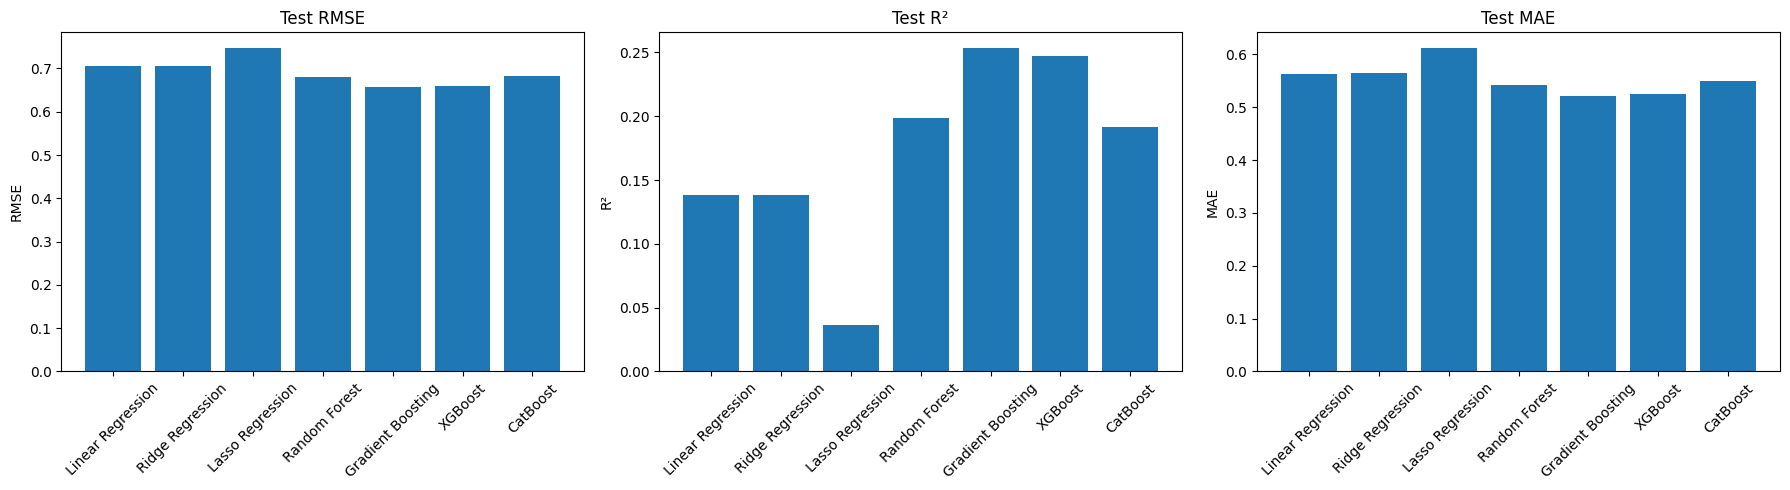

In [48]:
# Инициализация моделей с параметрами
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.1),
    'Random Forest': RandomForestRegressor(
        n_estimators=50,      # количество деревьев
        max_depth=3,          # ограничение глубині
        min_samples_split=20, #  минимальное количество сэмплов для разделения
        min_samples_leaf=10,  #  минимальное количество сэмплов в листе
        max_features=0.5,     # Используем только половину признаков
        random_state=42
    ),
    'Gradient Boosting': GradientBoostingRegressor(
        n_estimators=50,      #  количество деревьев
        max_depth=3,          #  ограничили глубину
        learning_rate=0.05,   #  уменьшили скорость обучения
        subsample=0.8,        #  сабсэмплинг
        random_state=42
    ),
    'XGBoost': xgb.XGBRegressor(
        n_estimators=50,      #  количество деревьев
        max_depth=3,          #  ограничили глубину
        learning_rate=0.05,   #  уменьшили скорость обучения
        subsample=0.8,        #  сабсэмплинг
        colsample_bytree=0.8, #  сабсэмплинг по признакам
        reg_alpha=0.1,        # L1 регуляризация
        reg_lambda=1.0,       # L2 регуляризация
        random_state=42,
        eval_metric='rmse'
    ),
    'CatBoost': cb.CatBoostRegressor(
        iterations=50,        #  количество итераций
        depth=3,              #  ограничили глубину
        learning_rate=0.05,   #  уменьшили скорость обучения
        subsample=0.8,        #  сабсэмплинг
        l2_leaf_reg=3.0,      #  L2 регуляризация
        random_state=42,
        verbose=False
    )
}
# Обучение и оценка базовых моделей
baseline_results = []
baseline_predictions = {}

for name, model in models.items():
    print(f"Обучение {name}...")
    results, y_pred = evaluate_model(model, X_train, X_test, y_train, y_test, name)
    baseline_results.append(results)
    baseline_predictions[name] = y_pred

# Результаты в DataFrame
baseline_df = pd.DataFrame(baseline_results)
print("\n=== РЕЗУЛЬТАТЫ БАЗОВЫХ МОДЕЛЕЙ ===")
print(baseline_df.round(4))

# Визуализация результатов
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# RMSE
axes[0].bar(baseline_df['Model'], baseline_df['Test_RMSE'])
axes[0].set_title('Test RMSE')
axes[0].set_ylabel('RMSE')
axes[0].tick_params(axis='x', rotation=45)

# R²
axes[1].bar(baseline_df['Model'], baseline_df['Test_R2'])
axes[1].set_title('Test R²')
axes[1].set_ylabel('R²')
axes[1].tick_params(axis='x', rotation=45)

# MAE
axes[2].bar(baseline_df['Model'], baseline_df['Test_MAE'])
axes[2].set_title('Test MAE')
axes[2].set_ylabel('MAE')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


Подбор гиперпараметров с использованием Optuna

In [49]:
def optimize_random_forest(X_train, y_train, n_trials=50):
    """Оптимизация гиперпараметров для Random Forest"""

    def objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 300),
            'max_depth': trial.suggest_int('max_depth', 4, 7),
            'min_samples_split': trial.suggest_int('min_samples_split', 10, 50),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 5, 20),
            'max_features': trial.suggest_float('max_features', 0.4, 0.8),
            'max_samples': trial.suggest_float('max_samples', 0.7, 0.9),
            'random_state': 42
        }

        model = RandomForestRegressor(**params)
        cv_scores = cross_val_score(model, X_train, y_train, cv=5,
                                   scoring='neg_mean_squared_error')
        return np.sqrt(-cv_scores.mean())

    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=n_trials)

    print(f"Random Forest - Лучший RMSE: {study.best_value:.4f}")
    print(f"Random Forest - Лучшие параметры: {study.best_params}")

    return study.best_params

In [50]:
def optimize_gradient_boosting(X_train, y_train, n_trials=50):
    """Оптимизация гиперпараметров для Gradient Boosting"""

    def objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 500),
            'max_depth': trial.suggest_int('max_depth', 3, 6),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.15),
            'subsample': trial.suggest_float('subsample', 0.7, 0.9),
            'min_samples_split': trial.suggest_int('min_samples_split', 10, 50),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 5, 20),
            'max_features': trial.suggest_float('max_features', 0.5, 0.9),
            'random_state': 42
        }

        model = GradientBoostingRegressor(**params)
        cv_scores = cross_val_score(model, X_train, y_train, cv=5,
                                   scoring='neg_mean_squared_error')
        return np.sqrt(-cv_scores.mean())

    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=n_trials)

    print(f"Gradient Boosting - Лучший RMSE: {study.best_value:.4f}")
    print(f"Gradient Boosting - Лучшие параметры: {study.best_params}")

    return study.best_params

In [51]:
def optimize_xgboost(X_train, y_train, n_trials=50):
    """Оптимизация гиперпараметров для XGBoost"""

    def objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 500),
            'max_depth': trial.suggest_int('max_depth', 3, 6),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.15),
            'subsample': trial.suggest_float('subsample', 0.7, 0.9),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 0.9),
            'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.6, 0.9),
            'reg_alpha': trial.suggest_float('reg_alpha', 0.1, 2.0),
            'reg_lambda': trial.suggest_float('reg_lambda', 1.0, 5.0),
            'min_child_weight': trial.suggest_int('min_child_weight', 3, 10),
            'random_state': 42,
            'eval_metric': 'rmse'
        }

        model = xgb.XGBRegressor(**params)
        cv_scores = cross_val_score(model, X_train, y_train, cv=5,
                                   scoring='neg_mean_squared_error')
        return np.sqrt(-cv_scores.mean())

    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=n_trials)

    print(f"XGBoost - Лучший RMSE: {study.best_value:.4f}")
    print(f"XGBoost - Лучшие параметры: {study.best_params}")

    return study.best_params

In [52]:
def optimize_catboost(X_train, y_train, n_trials=50):
    """Оптимизация гиперпараметров для CatBoost"""

    def objective(trial):
        params = {
            'iterations': trial.suggest_int('iterations', 100, 500),
            'depth': trial.suggest_int('depth', 4, 7),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.15),
            'subsample': trial.suggest_float('subsample', 0.7, 0.9),
            'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.6, 0.9),
            'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 3.0, 15.0),
            'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 5, 20),
            'random_state': 42,
            'verbose': False
        }

        model = cb.CatBoostRegressor(**params)
        cv_scores = cross_val_score(model, X_train, y_train, cv=5,
                                   scoring='neg_mean_squared_error')
        return np.sqrt(-cv_scores.mean())

    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=n_trials)

    print(f"CatBoost - Лучший RMSE: {study.best_value:.4f}")
    print(f"CatBoost - Лучшие параметры: {study.best_params}")

    return study.best_params

In [53]:
print("=== ПОДБОР ГИПЕРПАРАМЕТРОВ ===")

rf_best_params = optimize_random_forest(X_train, y_train, n_trials=30)
gb_best_params = optimize_gradient_boosting(X_train, y_train, n_trials=30)
xgb_best_params = optimize_xgboost(X_train, y_train, n_trials=30)
catb_best_params = optimize_catboost(X_train, y_train, n_trials=30)

[I 2025-06-17 17:33:47,451] A new study created in memory with name: no-name-9da9a5b5-99c9-456f-9458-6220f2f5fd55


=== ПОДБОР ГИПЕРПАРАМЕТРОВ ===


[I 2025-06-17 17:33:50,168] Trial 0 finished with value: 0.632839978971356 and parameters: {'n_estimators': 203, 'max_depth': 6, 'min_samples_split': 39, 'min_samples_leaf': 19, 'max_features': 0.5724374344957146, 'max_samples': 0.7749317161385697}. Best is trial 0 with value: 0.632839978971356.
[I 2025-06-17 17:33:53,027] Trial 1 finished with value: 0.6264924022178836 and parameters: {'n_estimators': 231, 'max_depth': 6, 'min_samples_split': 30, 'min_samples_leaf': 10, 'max_features': 0.48400816775307653, 'max_samples': 0.7133150836825888}. Best is trial 1 with value: 0.6264924022178836.
[I 2025-06-17 17:33:56,715] Trial 2 finished with value: 0.6370617830866225 and parameters: {'n_estimators': 294, 'max_depth': 4, 'min_samples_split': 50, 'min_samples_leaf': 19, 'max_features': 0.662755505517961, 'max_samples': 0.774551421242005}. Best is trial 1 with value: 0.6264924022178836.
[I 2025-06-17 17:33:59,574] Trial 3 finished with value: 0.6296175457457297 and parameters: {'n_estimators

Random Forest - Лучший RMSE: 0.6127
Random Forest - Лучшие параметры: {'n_estimators': 223, 'max_depth': 6, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': 0.7085281075357615, 'max_samples': 0.8952966153476892}


[I 2025-06-17 17:35:34,648] Trial 0 finished with value: 0.6502322398216932 and parameters: {'n_estimators': 323, 'max_depth': 3, 'learning_rate': 0.14727574286654083, 'subsample': 0.8909015572379692, 'min_samples_split': 39, 'min_samples_leaf': 20, 'max_features': 0.8515281545790078}. Best is trial 0 with value: 0.6502322398216932.
[I 2025-06-17 17:35:38,698] Trial 1 finished with value: 0.6276046522979817 and parameters: {'n_estimators': 356, 'max_depth': 3, 'learning_rate': 0.06844452660894504, 'subsample': 0.7559931778288317, 'min_samples_split': 18, 'min_samples_leaf': 18, 'max_features': 0.5987830700851424}. Best is trial 1 with value: 0.6276046522979817.
[I 2025-06-17 17:35:48,181] Trial 2 finished with value: 0.6474028875771753 and parameters: {'n_estimators': 400, 'max_depth': 6, 'learning_rate': 0.06537479589128595, 'subsample': 0.7000617375882775, 'min_samples_split': 29, 'min_samples_leaf': 10, 'max_features': 0.8813364481475805}. Best is trial 1 with value: 0.6276046522979

Gradient Boosting - Лучший RMSE: 0.6111
Gradient Boosting - Лучшие параметры: {'n_estimators': 189, 'max_depth': 5, 'learning_rate': 0.029690164715567045, 'subsample': 0.7443463535857686, 'min_samples_split': 47, 'min_samples_leaf': 20, 'max_features': 0.6861379778465574}


[I 2025-06-17 17:37:45,215] Trial 0 finished with value: 0.6391124062997895 and parameters: {'n_estimators': 396, 'max_depth': 5, 'learning_rate': 0.07246943121997776, 'subsample': 0.8006806215991653, 'colsample_bytree': 0.8401539552009772, 'colsample_bylevel': 0.880392743237689, 'reg_alpha': 0.9976158182792013, 'reg_lambda': 2.417332051772385, 'min_child_weight': 8}. Best is trial 0 with value: 0.6391124062997895.
[I 2025-06-17 17:37:46,289] Trial 1 finished with value: 0.6205737667691382 and parameters: {'n_estimators': 295, 'max_depth': 5, 'learning_rate': 0.040329963099478554, 'subsample': 0.8176515158964947, 'colsample_bytree': 0.6068712836168131, 'colsample_bylevel': 0.8863919750033633, 'reg_alpha': 0.5382448180244928, 'reg_lambda': 3.561105579606975, 'min_child_weight': 10}. Best is trial 1 with value: 0.6205737667691382.
[I 2025-06-17 17:37:47,885] Trial 2 finished with value: 0.6089330380012218 and parameters: {'n_estimators': 360, 'max_depth': 6, 'learning_rate': 0.0109645411

XGBoost - Лучший RMSE: 0.6068
XGBoost - Лучшие параметры: {'n_estimators': 167, 'max_depth': 5, 'learning_rate': 0.031421786313281554, 'subsample': 0.8307993092858397, 'colsample_bytree': 0.7469465037322487, 'colsample_bylevel': 0.6257470163151281, 'reg_alpha': 1.5814778926750452, 'reg_lambda': 3.154858716352113, 'min_child_weight': 8}


[I 2025-06-17 17:38:24,707] Trial 0 finished with value: 0.6054366672797299 and parameters: {'iterations': 176, 'depth': 7, 'learning_rate': 0.06862237398350514, 'subsample': 0.8658211156981862, 'colsample_bylevel': 0.7634878831699726, 'l2_leaf_reg': 10.15179779741189, 'min_data_in_leaf': 5}. Best is trial 0 with value: 0.6054366672797299.
[I 2025-06-17 17:38:26,265] Trial 1 finished with value: 0.608923404315798 and parameters: {'iterations': 459, 'depth': 4, 'learning_rate': 0.04316959864368515, 'subsample': 0.8445773826004923, 'colsample_bylevel': 0.8782488322066784, 'l2_leaf_reg': 6.778224430280168, 'min_data_in_leaf': 16}. Best is trial 0 with value: 0.6054366672797299.
[I 2025-06-17 17:38:27,243] Trial 2 finished with value: 0.6081089248300492 and parameters: {'iterations': 132, 'depth': 6, 'learning_rate': 0.10023193866241879, 'subsample': 0.76617848866717, 'colsample_bylevel': 0.6622810186711483, 'l2_leaf_reg': 14.532659889686624, 'min_data_in_leaf': 12}. Best is trial 0 with v

CatBoost - Лучший RMSE: 0.6041
CatBoost - Лучшие параметры: {'iterations': 183, 'depth': 7, 'learning_rate': 0.09692638224755806, 'subsample': 0.8773374118316327, 'colsample_bylevel': 0.7378706079142775, 'l2_leaf_reg': 11.43617002492605, 'min_data_in_leaf': 13}


Оптимизированные модели

In [54]:
optimized_models = {
    'Random Forest (Optimized)': RandomForestRegressor(**rf_best_params),
    'Gradient Boosting (Optimized)': GradientBoostingRegressor(**gb_best_params),
    'XGBoost (Optimized)': xgb.XGBRegressor(**xgb_best_params),
    'CatBoost (Optimized)': cb.CatBoostRegressor(**catb_best_params)
}

In [55]:
optimized_results = []
optimized_predictions = {}

for name, model in optimized_models.items():
    print(f"Обучение {name}...")
    results, y_pred = evaluate_model(model, X_train, X_test, y_train, y_test, name)
    optimized_results.append(results)
    optimized_predictions[name] = y_pred

# Результаты оптимизированных моделей
optimized_df = pd.DataFrame(optimized_results)
print(optimized_df.round(4))

# Сравнение с базовыми моделями
comparison_data = []

base_models_subset = baseline_df[baseline_df['Model'].isin([
    'Random Forest', 'Gradient Boosting', 'XGBoost', 'CatBoost'
])]

for _, base_row in base_models_subset.iterrows():
    model_name = base_row['Model']
    opt_row = optimized_df[optimized_df['Model'] == f"{model_name} (Optimized)"].iloc[0]

    comparison_data.append({
        'Model': model_name,
        'Base_Test_RMSE': base_row['Test_RMSE'],
        'Opt_Test_RMSE': opt_row['Test_RMSE'],
        'Improvement': base_row['Test_RMSE'] - opt_row['Test_RMSE'],
        'Base_Test_R2': base_row['Test_R2'],
        'Opt_Test_R2': opt_row['Test_R2']
    })

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.round(4))


Обучение Random Forest (Optimized)...
Обучение Gradient Boosting (Optimized)...
Обучение XGBoost (Optimized)...
Обучение CatBoost (Optimized)...
0:	learn: 0.6996694	total: 1.85ms	remaining: 336ms
1:	learn: 0.6898794	total: 4.58ms	remaining: 414ms
2:	learn: 0.6804245	total: 8.01ms	remaining: 480ms
3:	learn: 0.6702879	total: 10.4ms	remaining: 464ms
4:	learn: 0.6631674	total: 12.3ms	remaining: 437ms
5:	learn: 0.6563382	total: 15.5ms	remaining: 457ms
6:	learn: 0.6494381	total: 17.3ms	remaining: 436ms
7:	learn: 0.6428589	total: 19.3ms	remaining: 423ms
8:	learn: 0.6370127	total: 21.1ms	remaining: 409ms
9:	learn: 0.6324309	total: 23.5ms	remaining: 407ms
10:	learn: 0.6271753	total: 25.8ms	remaining: 404ms
11:	learn: 0.6230029	total: 28.3ms	remaining: 403ms
12:	learn: 0.6197582	total: 30.4ms	remaining: 398ms
13:	learn: 0.6158440	total: 32.9ms	remaining: 397ms
14:	learn: 0.6118968	total: 34.9ms	remaining: 391ms
15:	learn: 0.6093021	total: 37.3ms	remaining: 390ms
16:	learn: 0.6051161	total: 39.6m

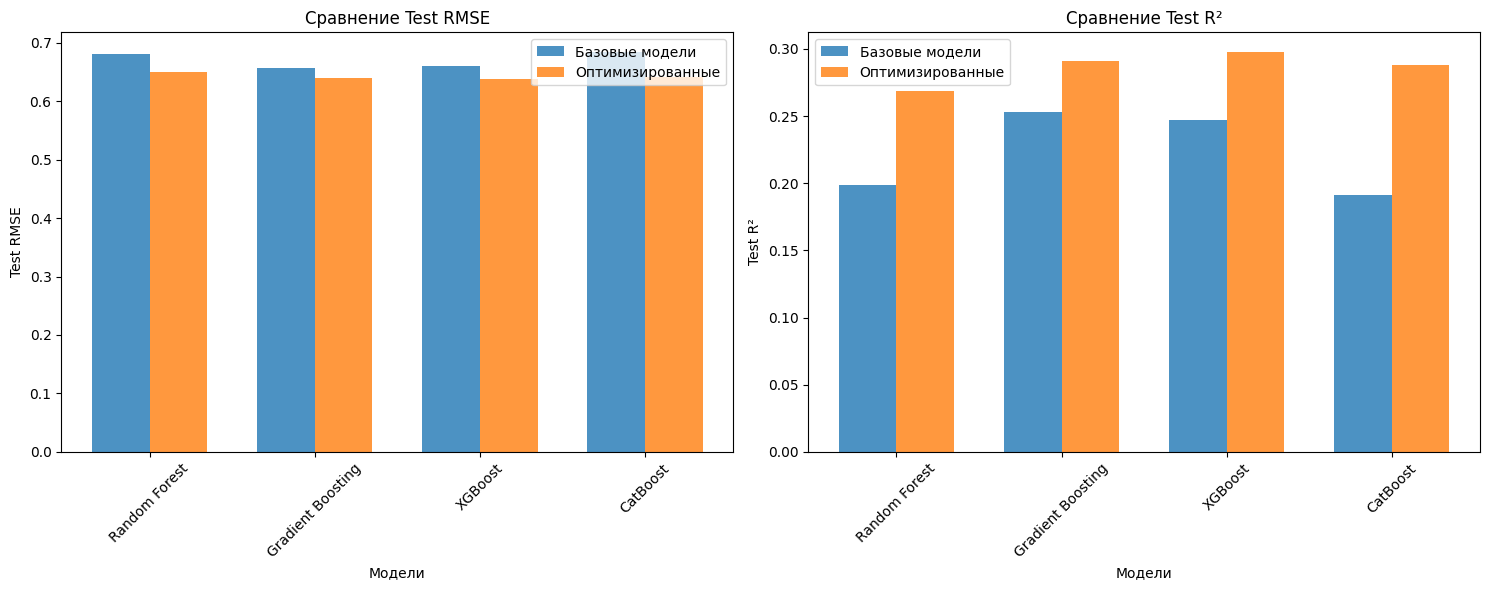

In [56]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# RMSE
x_pos = np.arange(len(comparison_df))
width = 0.35

axes[0].bar(x_pos - width/2, comparison_df['Base_Test_RMSE'], width,
           label='Базовые модели', alpha=0.8)
axes[0].bar(x_pos + width/2, comparison_df['Opt_Test_RMSE'], width,
           label='Оптимизированные', alpha=0.8)
axes[0].set_xlabel('Модели')
axes[0].set_ylabel('Test RMSE')
axes[0].set_title('Сравнение Test RMSE')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(comparison_df['Model'], rotation=45)
axes[0].legend()

# R2
axes[1].bar(x_pos - width/2, comparison_df['Base_Test_R2'], width,
           label='Базовые модели', alpha=0.8)
axes[1].bar(x_pos + width/2, comparison_df['Opt_Test_R2'], width,
           label='Оптимизированные', alpha=0.8)
axes[1].set_xlabel('Модели')
axes[1].set_ylabel('Test R²')
axes[1].set_title('Сравнение Test R²')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(comparison_df['Model'], rotation=45)
axes[1].legend()

plt.tight_layout()
plt.show()